In [61]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns #For heatmap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from preprocessing.preprocess_data import DataSet, make_categorical, ReLU, pred_to_delivery, remap
import catboost as cb

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)



In [62]:
#All
# selected_features = ['date_forecast', 'absolute_humidity_2m:gm3',
#        'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
#        'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
#        'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
#        'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
#        'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
#        'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
#        'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
#        'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
#        'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
#        'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
#        'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
#        'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
#        't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
#        'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
#        'wind_speed_w_1000hPa:ms']
selected_features = ['date_forecast', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms']

# selected_features = ['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
#        'clear_sky_energy_1h:J', 'clear_sky_rad:W',
#        'dew_point_2m:K',
#        'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
#        'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
#        'is_in_shadow:idx',
#        'msl_pressure:hPa', 'precip_5min:mm',
#        'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
#        'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
#        'snow_depth:cm', 'snow_drift:idx',
#        'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
#        'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
#        'total_cloud_cover:p', 'visibility:m', 
#        'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms']



made_features = ['location', 'is_in_shadow:idx']

drop_feature = 'diffuse_rad:W'

In [63]:

#Loading all data
data_collection = DataSet()

In [64]:
data_collection.select_features(selected_features)
data_collection.resample_to_hourly()
data_collection.remove_nans(drop_feature)
data_collection.fix_cat_features(location=True)
# data_collection.drop_bad_data()
data_collection.combine_obs_est()


In [65]:
local_test = True
y_scale = True

save = False
model_name = "cb_2"

k_b = 4.976
k_c = 5.735
if local_test:
    X_train, X_test, y_train, y_test = data_collection.local_train_test(y_scale=y_scale, k_b = k_b, k_c = k_c)

else:
    if y_scale:
        data_collection.scale_y_train()
    X_train, X_test, y_train = data_collection.train_test()
    

In [66]:
if 'is_in_shadow:idx' in made_features:
    X_train['is_in_shadow:idx'] = X_train['is_in_shadow:idx'].map(remap)
    X_test['is_in_shadow:idx'] = X_test['is_in_shadow:idx'].map(remap)


make_categorical(X_train,made_features)
X_train = X_train.rename(columns={'date_forecast': 'time'})
X_train = X_train.reset_index(drop=True)
X_train = X_train.drop('time', axis=1)

if 'date_calc' in X_train.columns:
    X_train = X_train.drop('date_calc', axis=1)

make_categorical(X_test,made_features)
X_test = X_test.rename(columns={'date_forecast': 'time'})
X_test = X_test.reset_index(drop=True)
X_test = X_test.drop('time', axis=1)

if 'date_calc' in X_test.columns:
    X_test = X_test.drop('date_calc', axis=1)

In [67]:
train_pool = cb.Pool(
    X_train,
    y_train,
    cat_features = made_features
)
if local_test:
    test_pool = cb.Pool(
        X_test,
        y_test,
        cat_features = made_features
    )
else:
    test_pool = cb.Pool(
        X_test,
        cat_features = made_features
    )

model = cb.CatBoostRegressor(
    iterations = 1000,
    depth = 9,
    learning_rate =0.01,
    loss_function ='MAE',
    cat_features = made_features
)

In [68]:
#train the model
model.fit(train_pool, silent=True)
# make the prediction using the resulting model
preds = model.predict(test_pool)

In [69]:
#scale back

if y_scale:
    length = int((X_test.shape[0]/3))
    if local_test:
        y_test_a = y_test[:length]
        y_test_b = y_test[length:2*length] / k_b
        y_test_c = y_test[2*length:3*length] / k_c
        y_test = pd.concat([y_test_a,y_test_b, y_test_c])

    pred_a = preds[:length]
    pred_b = preds[length:2*length] / k_b
    pred_c = preds[2*length:3*length] / k_c
    preds = np.concatenate([pred_a,pred_b, pred_c])



Total: MAE: 76.62617195954734
Total: MAE on ReLU of y_pred: 76.61091105379252
Total: MAE on abs(-) of y_pred: 76.61011155401205
A: MAE: 179.05926208015632
B: MAE: 23.91406519102241
C: MAE: 26.905188607463288


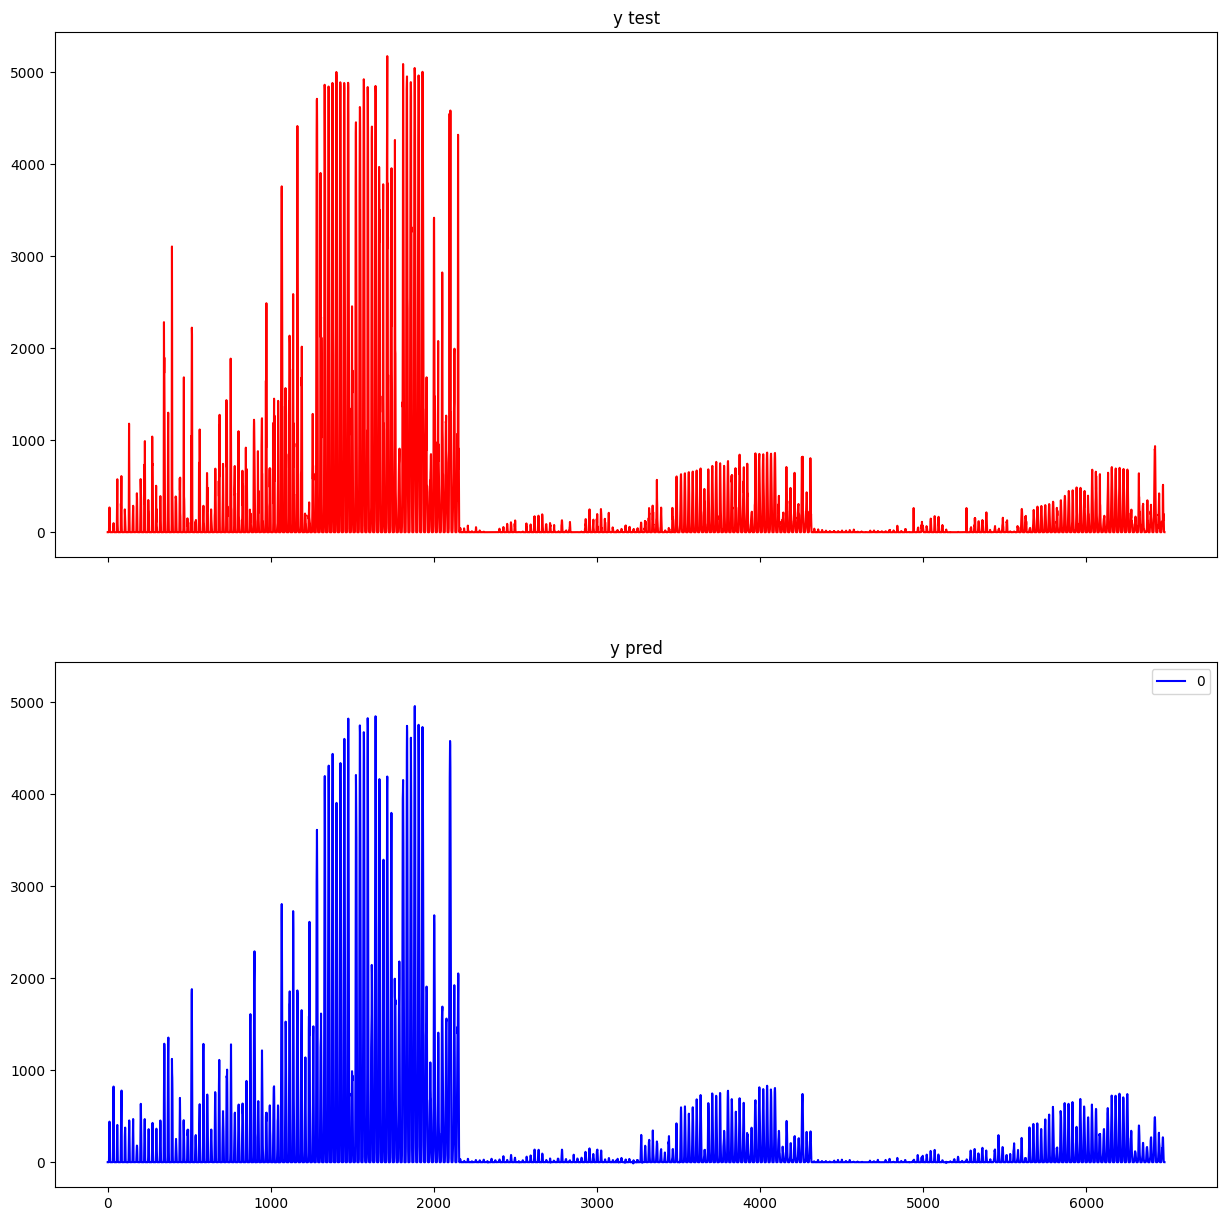

In [70]:
if local_test:
    print(f'Total: MAE: {mean_absolute_error(preds, y_test)}')
    print(f'Total: MAE on ReLU of y_pred: {mean_absolute_error(ReLU(preds), y_test)}')
    print(f'Total: MAE on abs(-) of y_pred: {mean_absolute_error(np.abs(preds), y_test)}')
    if y_scale:
        print(f'A: MAE: {mean_absolute_error(pred_a, y_test_a)}')
        print(f'B: MAE: {mean_absolute_error(pred_b, y_test_b)}')
        print(f'C: MAE: {mean_absolute_error(pred_c, y_test_c)}')

preds_df = pd.DataFrame(preds)

if local_test:
    fig, axs = plt.subplots(2,1,figsize = (15,15), sharex = True, sharey=True)
    y_test.plot(ax=axs[0], title='y test', color='red')
    preds_df.plot(ax=axs[1], title='y pred', color='blue')
else:
    preds_df.plot(title='y pred', color='blue')


In [71]:
if save:
    model.save_model("models/" + model_name)
    pred_to_delivery(ReLU(preds),'Delivered_preds/' + model_name + '.csv')